# Gaussian Processes using numpy kernel

(c) 2016 by Chris Fonnesbeck

Example of simple GP fit, adapted from Stan's [example-models repository](https://github.com/stan-dev/example-models/blob/master/misc/gaussian-process/gp-fit.stan).

This example builds a Gaussian process from scratch, to illustrate the underlying model. PyMC3 now includes a dedicated GP submodule which is going to be more usable for a wider variety of problems.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns
import theano.tensor as T

from pymc3 import Model, MvNormal, HalfCauchy, sample, traceplot, summary, find_MAP, NUTS, Deterministic
from theano import shared
from theano.tensor.nlinalg import matrix_inverse

print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.9.0


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

In [3]:
x = np.array([-5, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4.3, -4.2, -4.1, -4, 
-3.9, -3.8, -3.7, -3.6, -3.5, -3.4, -3.3, -3.2, -3.1, -3, -2.9, 
-2.8, -2.7, -2.6, -2.5, -2.4, -2.3, -2.2, -2.1, -2, -1.9, -1.8, 
-1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1, -0.9, -0.8, -0.7, 
-0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 
0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 
1.9, 2, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3, 3.1, 
3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4, 4.1, 4.2, 4.3, 4.4, 
4.5, 4.6, 4.7, 4.8, 4.9, 5])

y = np.array([1.04442478194401, 0.948306088493654, 0.357037759697332, 0.492336514646604, 
0.520651364364746, 0.112629866592809, 0.470995468454158, -0.168442254267804, 
0.0720344402575861, -0.188108980535916, -0.0160163306512027, 
-0.0388792158617705, -0.0600673630622568, 0.113568725264636, 
0.447160403837629, 0.664421188556779, -0.139510743820276, 0.458823971660986, 
0.141214654640904, -0.286957663528091, -0.466537724021695, -0.308185884317105, 
-1.57664872694079, -1.44463024170082, -1.51206214603847, -1.49393593601901, 
-2.02292464164487, -1.57047488853653, -1.22973445533419, -1.51502367058357, 
-1.41493587255224, -1.10140254663611, -0.591866485375275, -1.08781838696462, 
-0.800375653733931, -1.00764767602679, -0.0471028950122742, -0.536820626879737, 
-0.151688056391446, -0.176771681318393, -0.240094952335518, -1.16827876746502, 
-0.493597351974992, -0.831683011472805, -0.152347043914137, 0.0190364158178343, 
-1.09355955218051, -0.328157917911376, -0.585575679802941, -0.472837120425201, 
-0.503633622750049, -0.0124446353828312, -0.465529814250314, 
-0.101621725887347, -0.26988462590405, 0.398726664193302, 0.113805181040188, 
0.331353802465398, 0.383592361618461, 0.431647298655434, 0.580036473774238, 
0.830404669466897, 1.17919105883462, 0.871037583886711, 1.12290553424174, 
0.752564860804382, 0.76897960270623, 1.14738839410786, 0.773151715269892, 
0.700611498974798, 0.0412951045437818, 0.303526087747629, -0.139399513324585, 
-0.862987735433697, -1.23399179134008, -1.58924289116396, -1.35105117911049, 
-0.990144529089174, -1.91175364127672, -1.31836236129543, -1.65955735224704, 
-1.83516148300526, -2.03817062501248, -1.66764011409214, -0.552154350554687, 
-0.547807883952654, -0.905389222477036, -0.737156477425302, -0.40211249920415, 
0.129669958952991, 0.271142753510592, 0.176311762529962, 0.283580281859344, 
0.635808289696458, 1.69976647982837, 1.10748978734239, 0.365412229181044, 
0.788821368082444, 0.879731888124867, 1.02180766619069, 0.551526067300283])

N = len(y)

We will use a squared exponential covariance function, which relies on the squared distances between observed points in the data.

In [4]:
squared_distance = lambda x, y: np.array([[(x[i] - y[j])**2 for i in range(len(x))] for j in range(len(y))])

In [5]:
with Model() as gp_fit:
    
    μ = np.zeros(N)
    
    η_sq = HalfCauchy('η_sq', 5)
    ρ_sq = HalfCauchy('ρ_sq', 5)
    σ_sq = HalfCauchy('σ_sq', 5)
    
    D = squared_distance(x, x)
    
    # Squared exponential
    Σ = T.fill_diagonal(η_sq * T.exp(-ρ_sq * D), η_sq + σ_sq)
    
    obs = MvNormal('obs', μ, Σ, observed=y)

This is what our initial covariance matrix looks like. Intuitively, every data point's Y-value correlates with points according to their squared distances.

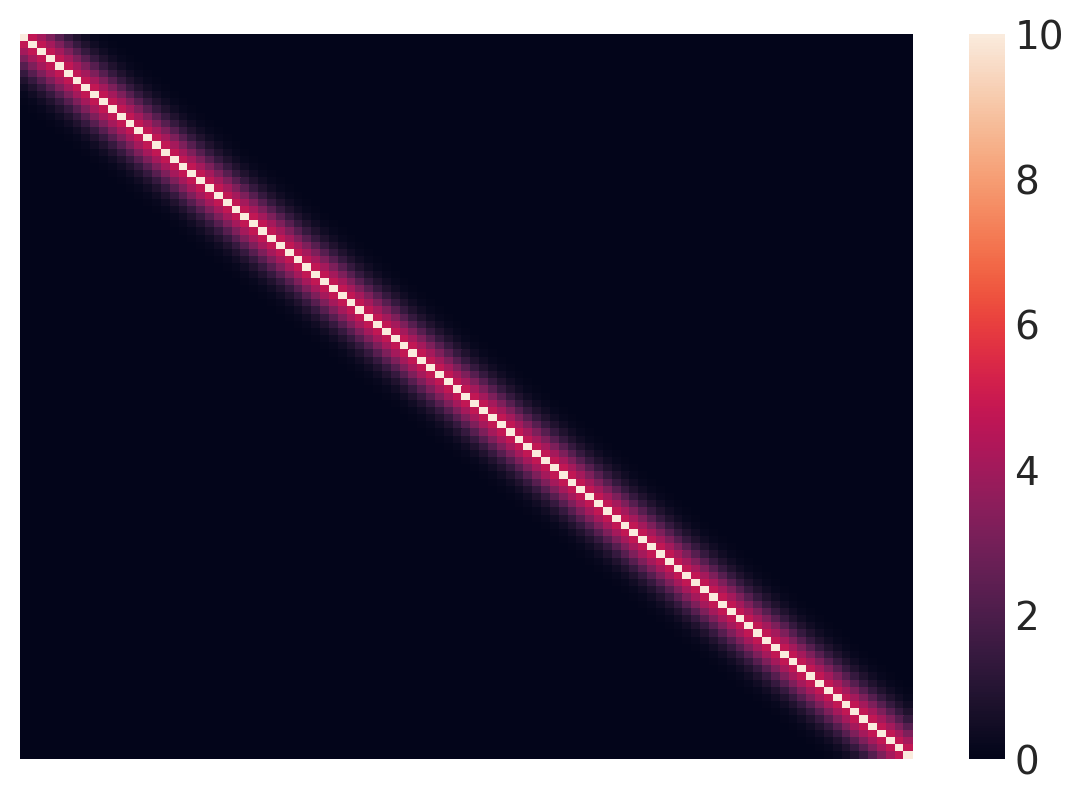

In [6]:
sns.heatmap(Σ.tag.test_value, xticklabels=False, yticklabels=False)

The following generates predictions from the GP model in a grid of values:

In [7]:
with gp_fit:
    
    # Prediction over grid
    xgrid = np.linspace(-6, 6)
    D_pred = squared_distance(xgrid, xgrid)
    D_off_diag = squared_distance(x, xgrid)
    
    # Covariance matrices for prediction
    Σ_pred = η_sq * T.exp(-ρ_sq * D_pred)
    Σ_off_diag = η_sq * T.exp(-ρ_sq * D_off_diag)
    
    # Posterior mean
    μ_post = Deterministic('μ_post', T.dot(T.dot(Σ_off_diag, matrix_inverse(Σ)), y))
    # Posterior covariance
    Σ_post = Deterministic('Σ_post', Σ_pred - T.dot(T.dot(Σ_off_diag, matrix_inverse(Σ)), Σ_off_diag.T))

In [8]:
with gp_fit:
    svgd_approx = pm.fit(400, method='svgd', inf_kwargs=dict(n_particles=500))

/env/miniconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


In [9]:
gp_trace = svgd_approx.sample(1000)

/dependencies/arviz/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/dependencies/arviz/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


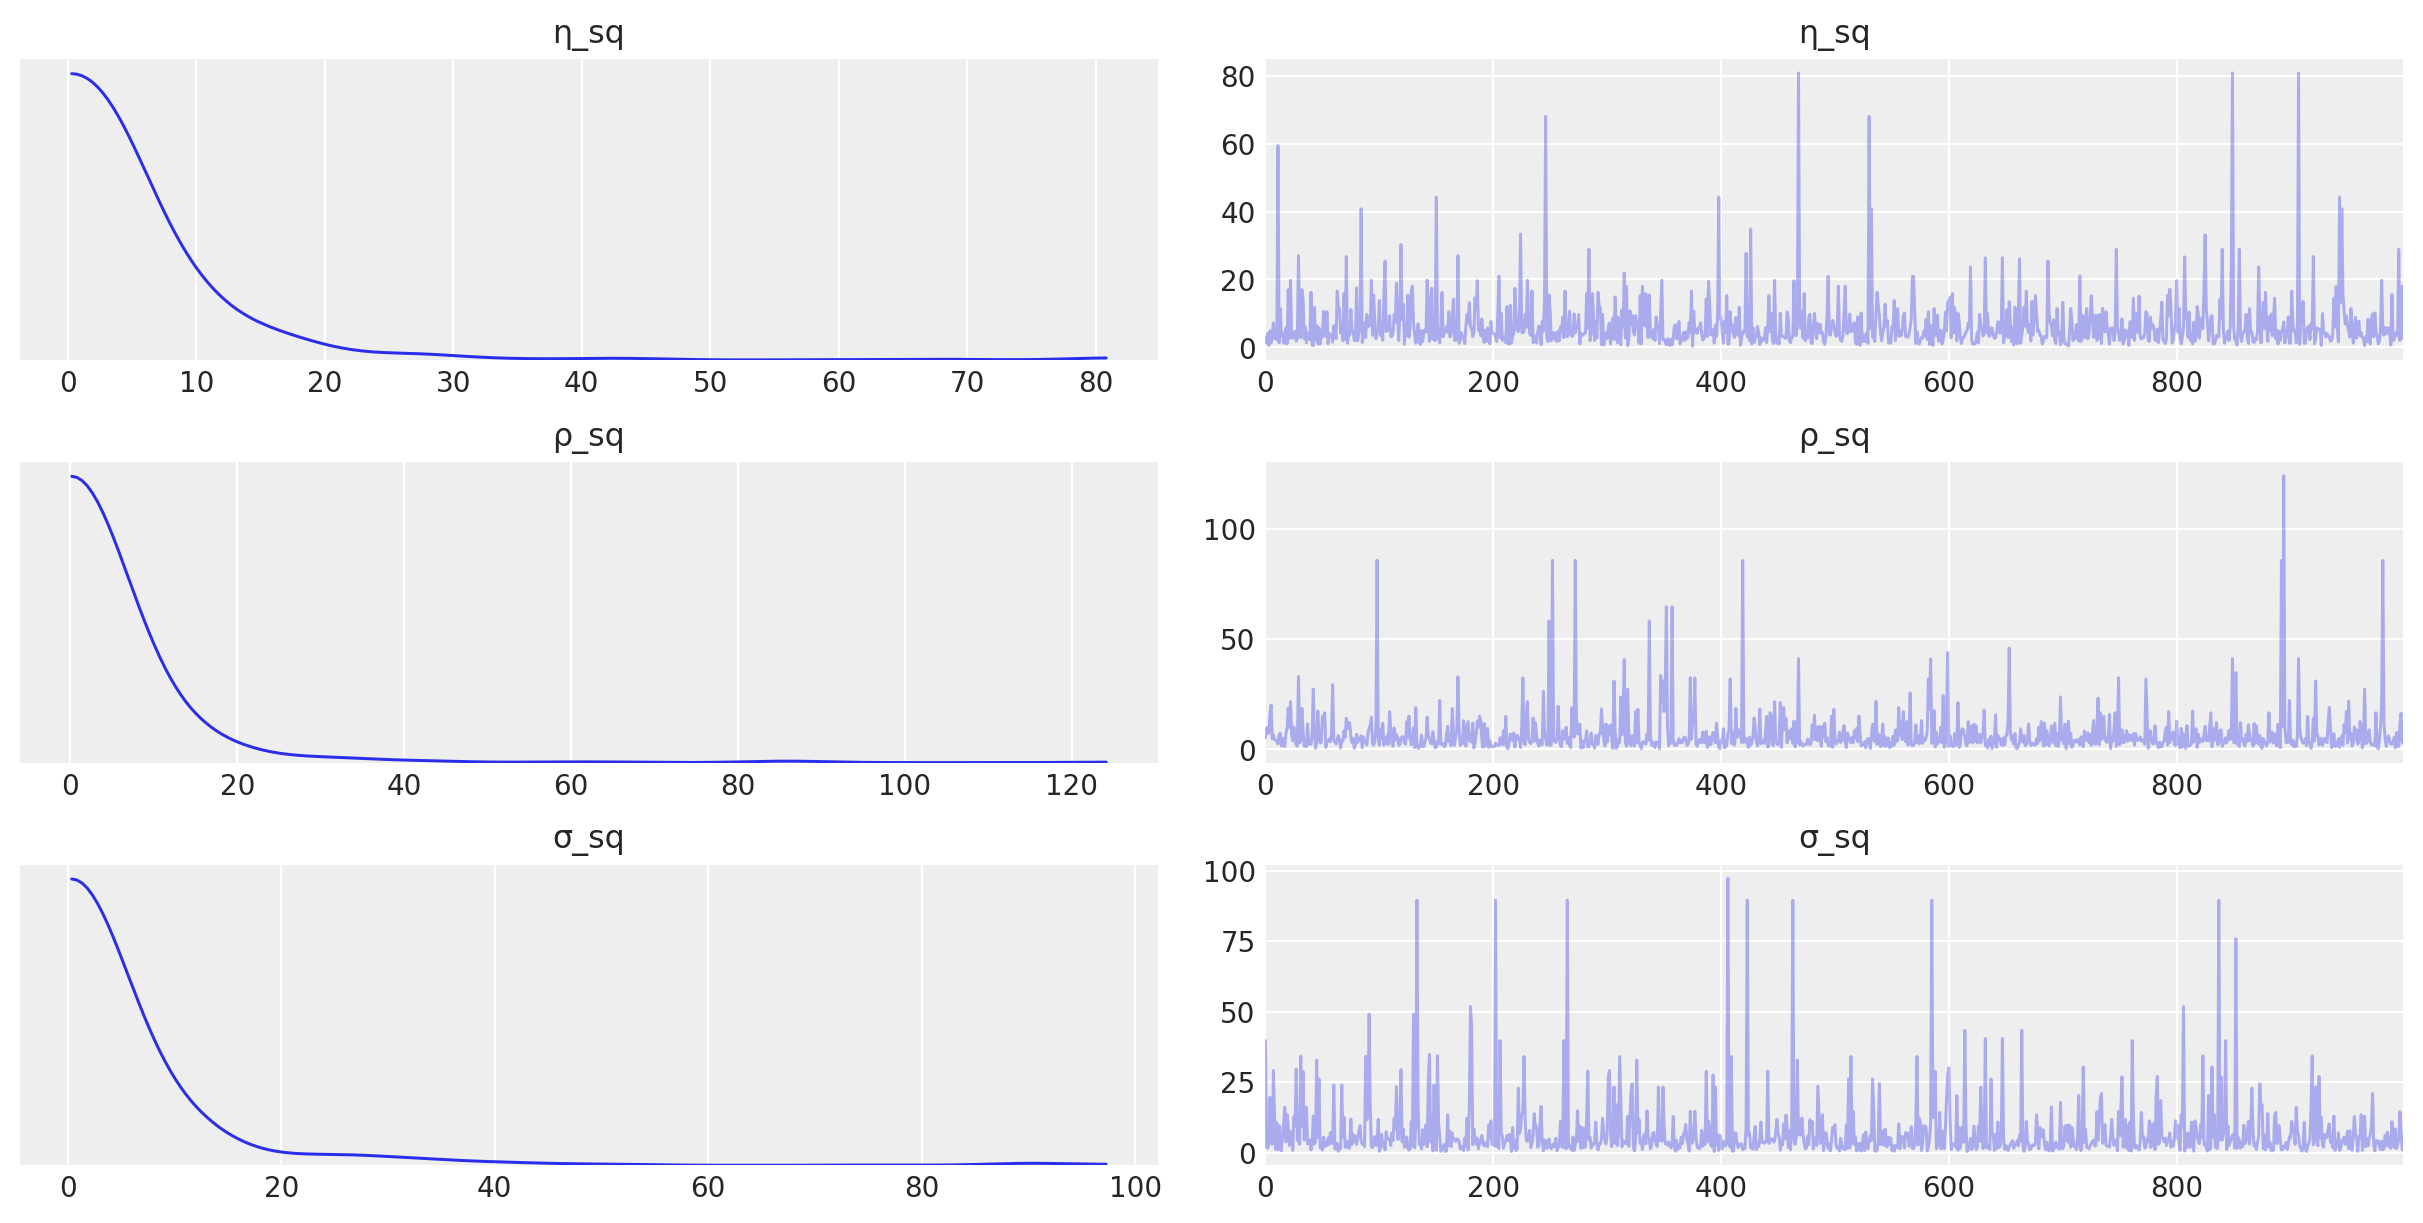

In [10]:
traceplot(gp_trace, var_names=['η_sq', 'ρ_sq', 'σ_sq']);

Sample from the posterior GP

In [11]:
y_pred = [np.random.multivariate_normal(m, S) for m, S in zip(gp_trace['μ_post'], gp_trace['Σ_post'])]

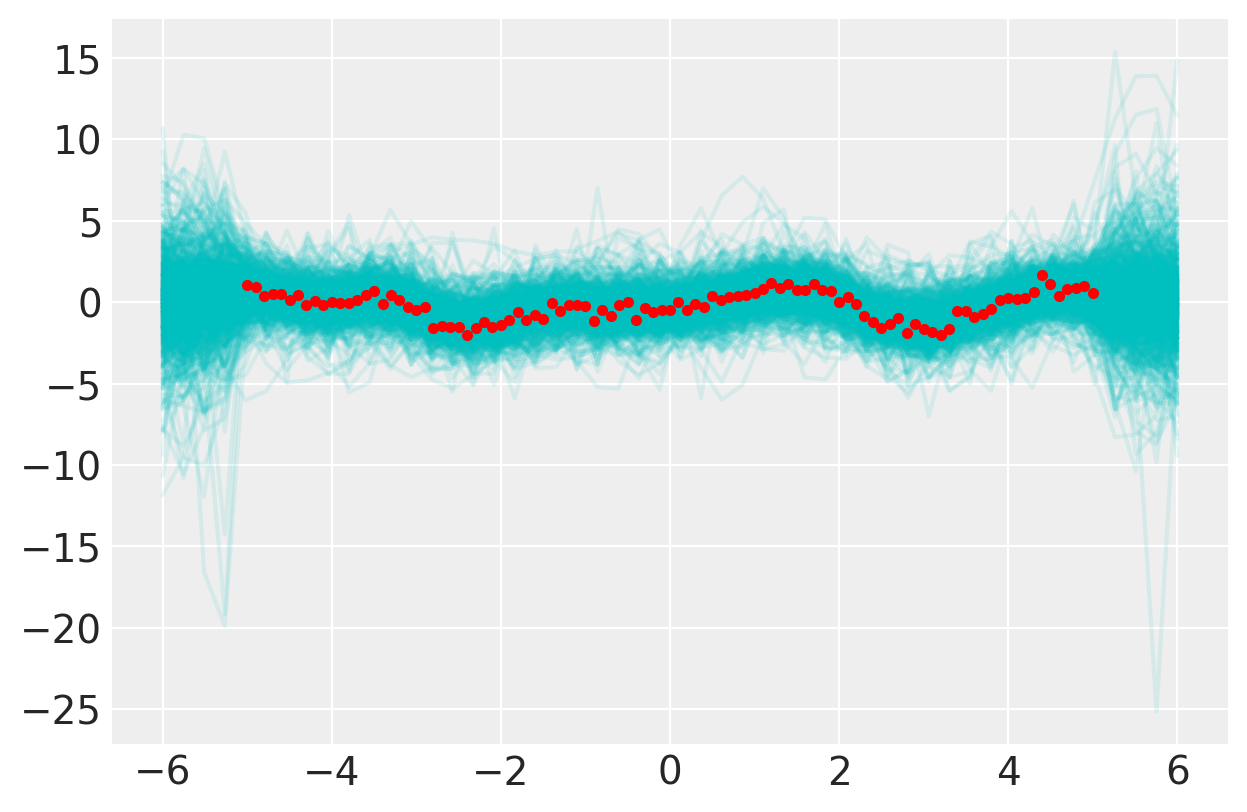

In [12]:
for yp in y_pred:
    plt.plot(np.linspace(-6, 6), yp, 'c-', alpha=0.1);
plt.plot(x, y, 'r.')

In [13]:
%load_ext watermark
%watermark -n -u -v -iv -w

numpy   1.18.5
arviz   0.8.3
seaborn 0.10.1
pymc3   3.9.0
last updated: Fri Jun 12 2020 

CPython 3.7.7
IPython 7.15.0
watermark 2.0.2
